In [1]:
import argparse 
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import time
import json
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
from unet import Unet_3D
from glob import glob
from monai.data import partition_dataset
from torch.utils.data import RandomSampler
from dataset import BrainTumourData
print_config()

/home/ron/Classes/MIC/PA2/med_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/ron/Classes/MIC/PA2/med_env/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.1
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.2.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = Fa

In [2]:
root_dir = 'Task01_BrainTumour'


with open(os.path.join(root_dir,'dataset.json'), 'r+') as file:
    metadata = json.load(file)


for dat in metadata['training']:
    img_path = os.path.normpath(dat['image'])
    lab_path = os.path.normpath(dat['label'])
    dat['image'] = os.path.join(root_dir,img_path)
    dat['label'] = os.path.join(root_dir,lab_path)

with open('dataset.json','w') as f:
    json.dump(metadata,f)

data = metadata['training']

In [3]:
set_determinism(seed=0)

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d
    

# class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
#     """
#     Convert labels to multi channels based on brats classes:
#     label 1 is the necrotic and non-enhancing tumor core
#     label 2 is the peritumoral edema
#     label 4 is the GD-enhancing tumor
#     The possible classes are TC (Tumor core), WT (Whole tumor)
#     and ET (Enhancing tumor).

#     """

#     def __call__(self, data):
#         d = dict(data)
#         for key in self.keys:
#             result = []
#             # merge label 1 and label 4 to construct TC
#             result.append(torch.logical_or(d[key] == 1, d[key] == 4))
#             # merge labels 1, 2 and 4 to construct WT
#             result.append(torch.logical_or(torch.logical_or(d[key] == 1, d[key] == 2), d[key] == 4))
#             # label 1 is ET
#             result.append(d[key] == 1)
#             d[key] = torch.stack(result, axis=0).float()
#         return d

In [5]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [6]:
# dataset = CacheDataset(
#     data=data,
#     transform=train_transform,
#     cache_rate=0.0,
#     num_workers=4,
#     progress=False,
# )

# sampler = RandomSampler(dataset, replacement=True, num_samples=int(0.8*len(dataset)))

# train_loader = DataLoader(dataset, batch_size=1, num_workers=4, sampler=sampler)
# val_loader = DataLoader(dataset, batch_size=1, num_workers=4, sampler=sampler)

In [7]:
# # here we don't cache any data in case out of memory issue
# train_ds = DecathlonDataset(
#     root_dir=root_dir,
#     task="Task01_BrainTumour",
#     transform=train_transform,
#     section="training",
#     download=True,
#     cache_rate=0.0,
#     num_workers=4,
# )
# train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
# val_ds = DecathlonDataset(
#     root_dir=root_dir,
#     task="Task01_BrainTumour",
#     transform=val_transform,
#     section="validation",
#     download=False,
#     cache_rate=0.0,
#     num_workers=4,
# )
# val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

In [8]:
# import random

# train_data = random.sample(data, int(0.8 * len(data)))
# val_data = [d for d in data if d not in train_data]

# print(len(train_data))
# print()
# print(len(val_data))

# print(train_data)

# # train_ds = Dataset(data['image'][train_idx], data['label'][train_idx], transform=train_transform)
# # val_ds = Dataset(data['image'][val_idx], data['label'][val_idx], transform=val_transform)

In [9]:
get_data = BrainTumourData()
train_ds, val_ds, train_loader, val_loader = get_data()

image shape: torch.Size([4, 240, 240, 155])


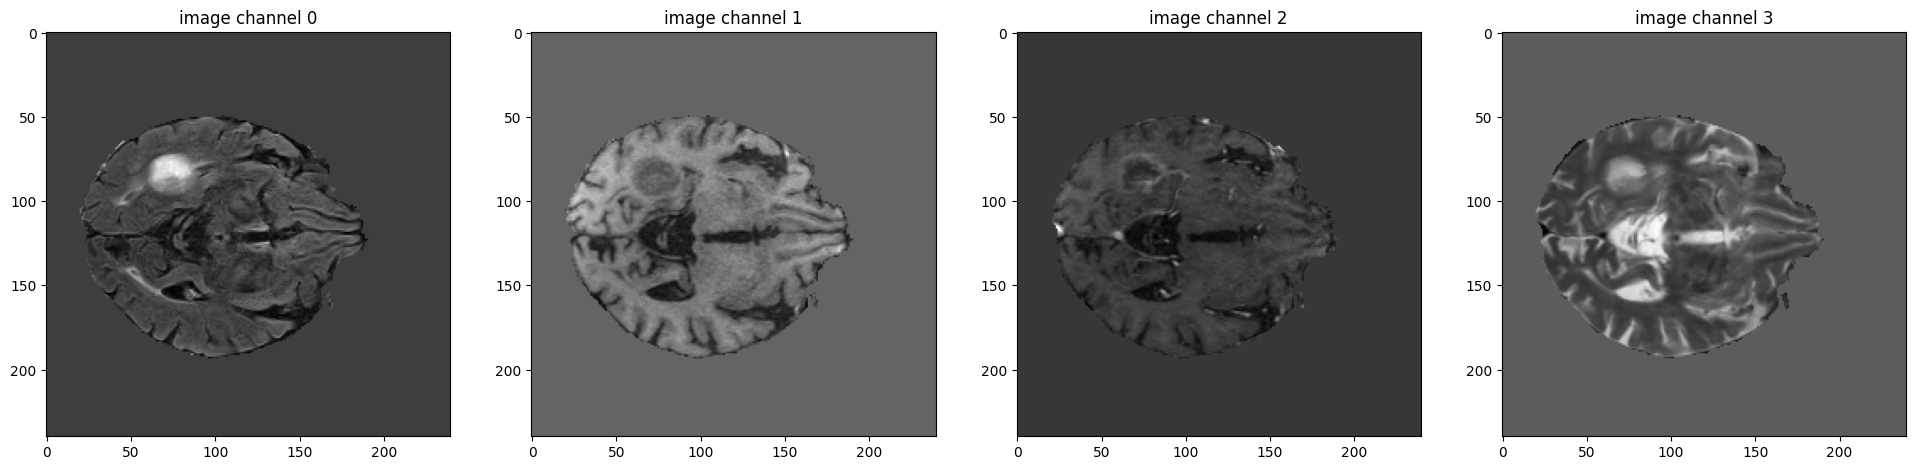

label shape: torch.Size([3, 240, 240, 155])


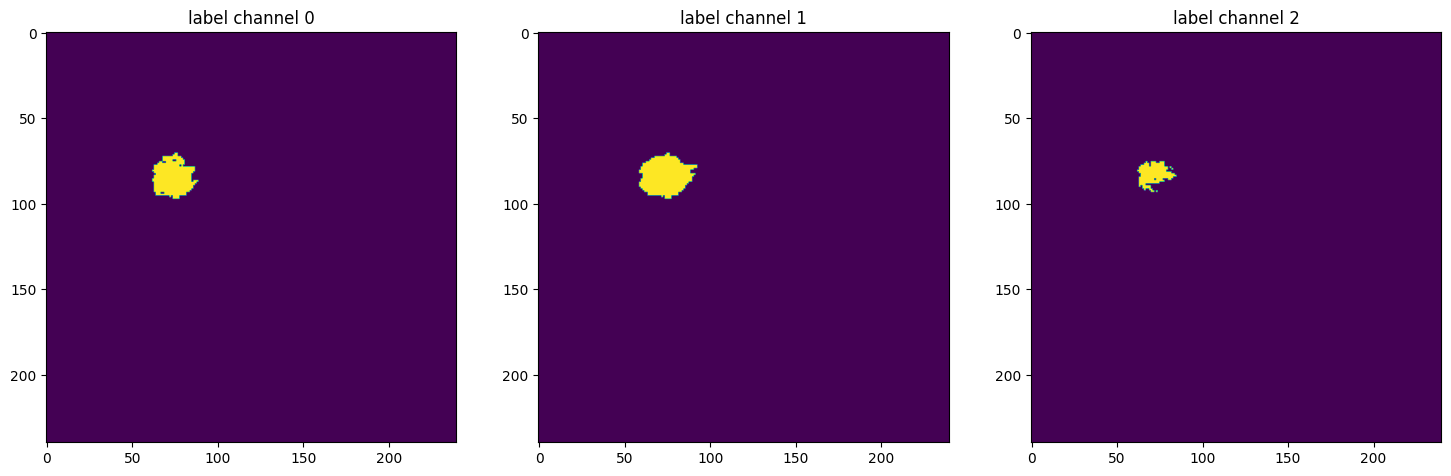

In [10]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [11]:
# parser = argparse.ArgumentParser()
# parser.add_argument('num_epochs', type=int, default=200)
# parser.add_argument('batch_size', type=int, default=64)
# parser.add_argument('num_workers', type=int, defaut=6)
# parser.add_argument('')


In [21]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
# model = SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=16,
#     in_channels=4,
#     out_channels=3,
#     dropout_prob=0.2,
# ).to(device)

from monai.networks.nets import UNet

print(UNet)

model = UNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=3,
    channels=(4,8,16),
    strides=(2,2),
    kernel_size=3, 
    up_kernel_size=3,
    act='PRELU',
    norm='INSTANCE',
).to(device)


loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

<class 'monai.networks.nets.unet.UNet'>


In [23]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        inputs = inputs[:,:3,:,:,:]
        # labels = labels[:,:3,:,:,:]
        # print(inputs.shape)
        # print(labels.shape)


        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300
1/387, train_loss: 0.9561, step time: 0.0716
2/387, train_loss: 0.9669, step time: 0.0751
3/387, train_loss: 0.9730, step time: 0.0806
4/387, train_loss: 0.9521, step time: 0.0774
5/387, train_loss: 0.9792, step time: 0.0604
6/387, train_loss: 0.9437, step time: 0.0637
7/387, train_loss: 0.9770, step time: 0.0635
8/387, train_loss: 0.9945, step time: 0.0722
9/387, train_loss: 0.9785, step time: 0.0703
10/387, train_loss: 0.9430, step time: 0.0679
11/387, train_loss: 0.9572, step time: 0.0654
12/387, train_loss: 0.9685, step time: 0.0689
13/387, train_loss: 0.9618, step time: 0.0695
14/387, train_loss: 0.9811, step time: 0.0620
15/387, train_loss: 0.9529, step time: 0.0636
16/387, train_loss: 0.9759, step time: 0.0850
17/387, train_loss: 0.9965, step time: 0.0685
18/387, train_loss: 0.9757, step time: 0.0680
19/387, train_loss: 0.9875, step time: 0.0655
20/387, train_loss: 0.9607, step time: 0.0705
21/387, train_loss: 0.9742, step time: 0.0731
22/387, train_loss: 

KeyboardInterrupt: 

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")
